<a href="https://colab.research.google.com/github/fake-news-unal/fake-news/blob/main/K_means%2Clogistica%2Cbosque%2Carbol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Importar librerías
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

# Importar keras
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional
from tensorflow.keras.models import Model

# Para la matrix de confusion
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

### Datos

In [1]:
from google.colab import files
files.upload()

Saving Fake.csv to Fake (2).csv
Saving True.csv to True (2).csv


In [3]:
#Lectura de datos
df_fake = pd.read_csv('Fake.csv')
df_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [4]:
#Lectura de datos
df_true= pd.read_csv('True.csv')
df_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


##### Registros nulos en ele archivo

In [5]:
df_true.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [6]:
df_fake.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

### Agregar columna de identificación de fake news

In [7]:
df_true['isfake'] = 1
df_true.head()

,title,text,subject,date,isfake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [8]:
df_fake['isfake'] = 0
df_fake.head()

,title,text,subject,date,isfake
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [9]:
df = pd.concat([df_true, df_fake]).reset_index(drop = True)

#### Combinanción de título y texto

In [10]:
df['original'] = df['title'] + ' ' + df['text']
df.head()

,title,text,subject,date,isfake,original
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,"As U.S. budget fight looms, Republicans flip t..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1,U.S. military to accept transgender recruits o...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1,Senior U.S. Republican senator: 'Let Mr. Muell...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1,FBI Russia probe helped by Australian diplomat...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1,Trump wants Postal Service to charge 'much mor...


#### Stopwords

In [11]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
df['original'][0]

'As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non

In [13]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [14]:
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [15]:
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
            result.append(token)
            
    return result

In [16]:
df['clean'] = df['original'].apply(preprocess)
df.head()

,title,text,subject,date,isfake,original,clean
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,"As U.S. budget fight looms, Republicans flip t...","[budget, fight, looms, republicans, flip, fisc..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1,U.S. military to accept transgender recruits o...,"[military, accept, transgender, recruits, mond..."
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1,Senior U.S. Republican senator: 'Let Mr. Muell...,"[senior, republican, senator, mueller, washing..."
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1,FBI Russia probe helped by Australian diplomat...,"[russia, probe, helped, australian, diplomat, ..."
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1,Trump wants Postal Service to charge 'much mor...,"[trump, wants, postal, service, charge, amazon..."


In [17]:
print(df['clean'][0])

['budget', 'fight', 'looms', 'republicans', 'flip', 'fiscal', 'script', 'washington', 'reuters', 'head', 'conservative', 'republican', 'faction', 'congress', 'voted', 'month', 'huge', 'expansion', 'national', 'debt', 'cuts', 'called', 'fiscal', 'conservative', 'sunday', 'urged', 'budget', 'restraint', 'keeping', 'sharp', 'pivot', 'republicans', 'representative', 'mark', 'meadows', 'speaking', 'face', 'nation', 'drew', 'hard', 'line', 'federal', 'spending', 'lawmakers', 'bracing', 'battle', 'january', 'return', 'holidays', 'wednesday', 'lawmakers', 'begin', 'trying', 'pass', 'federal', 'budget', 'fight', 'likely', 'linked', 'issues', 'immigration', 'policy', 'november', 'congressional', 'election', 'campaigns', 'approach', 'republicans', 'seek', 'control', 'congress', 'president', 'donald', 'trump', 'republicans', 'want', 'budget', 'increase', 'military', 'spending', 'democrats', 'want', 'proportional', 'increases', 'defense', 'discretionary', 'spending', 'programs', 'support', 'educati

### Palabras en el dataset

In [18]:
list_of_words = []
for i in df.clean:
    for j in i:
        list_of_words.append(j)
        
list_of_words[:10]

['budget',
 'fight',
 'looms',
 'republicans',
 'flip',
 'fiscal',
 'script',
 'washington',
 'reuters',
 'head']

In [19]:
len(list_of_words)

9277072

In [20]:
total_words = len(list(set(list_of_words)))
total_words

108705

In [21]:
df['clean_joined'] = df['clean'].apply(lambda x: " ".join(x))

df.head()

,title,text,subject,date,isfake,original,clean,clean_joined
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,"As U.S. budget fight looms, Republicans flip t...","[budget, fight, looms, republicans, flip, fisc...",budget fight looms republicans flip fiscal scr...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1,U.S. military to accept transgender recruits o...,"[military, accept, transgender, recruits, mond...",military accept transgender recruits monday pe...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1,Senior U.S. Republican senator: 'Let Mr. Muell...,"[senior, republican, senator, mueller, washing...",senior republican senator mueller washington r...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1,FBI Russia probe helped by Australian diplomat...,"[russia, probe, helped, australian, diplomat, ...",russia probe helped australian diplomat washin...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1,Trump wants Postal Service to charge 'much mor...,"[trump, wants, postal, service, charge, amazon...",trump wants postal service charge amazon shipm...


In [22]:
df['clean_joined'][0]

'budget fight looms republicans flip fiscal script washington reuters head conservative republican faction congress voted month huge expansion national debt cuts called fiscal conservative sunday urged budget restraint keeping sharp pivot republicans representative mark meadows speaking face nation drew hard line federal spending lawmakers bracing battle january return holidays wednesday lawmakers begin trying pass federal budget fight likely linked issues immigration policy november congressional election campaigns approach republicans seek control congress president donald trump republicans want budget increase military spending democrats want proportional increases defense discretionary spending programs support education scientific research infrastructure public health environmental protection trump administration willing going increase defense discretionary spending percent meadows chairman small influential house freedom caucus said program democrats saying need government raise 

### Partición del dataset

In [23]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.clean_joined, df.isfake, test_size = 0.2)

In [24]:
from nltk import word_tokenize
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer

tokenizer = Tokenizer(num_words = total_words)
tokenizer.fit_on_texts(x_train)
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

In [25]:
print("Texto original (limpio) \n",df.clean_joined[0],"\n Texto Tokenizado : ",train_sequences[0])

Texto original (limpio) 
 budget fight looms republicans flip fiscal script washington reuters head conservative republican faction congress voted month huge expansion national debt cuts called fiscal conservative sunday urged budget restraint keeping sharp pivot republicans representative mark meadows speaking face nation drew hard line federal spending lawmakers bracing battle january return holidays wednesday lawmakers begin trying pass federal budget fight likely linked issues immigration policy november congressional election campaigns approach republicans seek control congress president donald trump republicans want budget increase military spending democrats want proportional increases defense discretionary spending programs support education scientific research infrastructure public health environmental protection trump administration willing going increase defense discretionary spending percent meadows chairman small influential house freedom caucus said program democrats sayi

### Word2vec (Vectorización)

In [26]:
#Importando librerías
import string # python library
import re # regex library
from gensim.parsing.preprocessing import preprocess_string, strip_tags, strip_punctuation, strip_multiple_whitespaces, strip_numeric, remove_stopwords, strip_short # Preprocesssing
from gensim.models import Word2Vec # Word2vec

from sklearn import cluster # Kmeans clustering
from sklearn import metrics # Metrics for evaluation
from sklearn.decomposition import PCA #PCA
from sklearn.manifold import TSNE #TSNE

In [27]:
CUSTOM_FILTERS = [lambda x: x.lower(), strip_tags, strip_punctuation, strip_multiple_whitespaces, strip_numeric, remove_stopwords, strip_short]

processed_data = []
processed_labels = []

for index, row in df.iterrows():
    words_broken_up = preprocess_string(row['original'], CUSTOM_FILTERS)
    # Esto elimina cualquier campo que pueda quedar en blanco después del preprocesamiento.
    if len(words_broken_up) > 0:
        processed_data.append(words_broken_up)
        processed_labels.append(row['isfake'])

In [28]:
model = Word2Vec(processed_data, min_count=1)

In [29]:
model.wv.most_similar("country")

[('nation', 0.8224654793739319),
 ('america', 0.687254786491394),
 ('countries', 0.5962079763412476),
 ('america’s', 0.5636675357818604),
 ('country’s', 0.5585253238677979),
 ('europe', 0.5361539721488953),
 ('planet', 0.5332760810852051),
 ('continent', 0.5262622237205505),
 ('prosperous', 0.5070300102233887),
 ('abroad', 0.4987577795982361)]

In [31]:
# Obtener el vector de una oración basado en el promedio de todos los vectores de palabras en la oración
# Obtenemos el promedio ya que esto representa diferentes longitudes de oraciones
def ReturnVector(x):
    try:
        return model[x]
    except:
        return np.zeros(100)
    
def Sentence_Vector(sentence):
    word_vectors = list(map(lambda x: ReturnVector(x), sentence))
    return np.average(word_vectors, axis=0).tolist()

X = []
for data_x in processed_data:
    X.append(Sentence_Vector(data_x))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


In [32]:
X_np = np.array(X)
X_np.shape

(44898, 100)

# ***K-means***

In [61]:
# Training for 2 clusters (Fake and Real)
kmeans = cluster.KMeans(n_clusters=2, verbose=1)

# Fit predict will return labels
clustered = kmeans.fit_predict(X_np)

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 447297.1766653502
start iteration
done sorting
end inner loop
Iteration 1, inertia 441831.00539863337
start iteration
done sorting
end inner loop
Iteration 2, inertia 439732.64824481634
start iteration
done sorting
end inner loop
Iteration 3, inertia 438387.4471097791
start iteration
done sorting
end inner loop
Iteration 4, inertia 436971.83519680804
start iteration
done sorting
end inner loop
Iteration 5, inertia 434715.5997445643
start iteration
done sorting
end inner loop
Iteration 6, inertia 429590.8082263125
start iteration
done sorting
end inner loop
Iteration 7, inertia 422342.6874538203
start iteration
done sorting
end inner loop
Iteration 8, inertia 415705.2299921604
start iteration
done sorting
end inner loop
Iteration 9, inertia 411420.5210031419
start iteration
done sorting
end inner loop
Iteration 10, inertia 409696.1056186997
start iteration
done sorting
end inner loop
Iteration 11, i

In [62]:
testing_df = {'Sentence': processed_data, 'Labels': processed_labels, 'Prediction': clustered}
testing_df = pd.DataFrame(data=testing_df)

testing_df.head(10)

,Sentence,Labels,Prediction
0,"[budget, fight, looms, republicans, flip, fisc...",1,1
1,"[military, accept, transgender, recruits, mond...",1,1
2,"[senior, republican, senator, let, mueller, jo...",1,1
3,"[fbi, russia, probe, helped, australian, diplo...",1,1
4,"[trump, wants, postal, service, charge, amazon...",1,1
5,"[white, house, congress, prepare, talks, spend...",1,1
6,"[trump, says, russia, probe, fair, timeline, u...",1,1
7,"[factbox, trump, twitter, dec, approval, ratin...",1,0
8,"[trump, twitter, dec, global, warming, followi...",1,0
9,"[alabama, official, certify, senator, elect, j...",1,0


In [63]:
correct = 0
incorrect = 0
for index, row in testing_df.iterrows():
    if row['Labels'] == row['Prediction']:
        correct += 1
    else:
        incorrect += 1
        
print("Correctly clustered news: " + str((correct*100)/(correct+incorrect)) + "%")

Correctly clustered news: 83.31996970911845%


In [36]:
# PCA 
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_np)

PCA_df = pd.DataFrame(pca_result)
PCA_df['cluster'] = clustered
PCA_df.columns = ['x1','x2','cluster']

In [38]:
# T-SNE
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(pca_result)

TSNE_df = pd.DataFrame(tsne_result)
TSNE_df['cluster'] = clustered
TSNE_df.columns = ['x1','x2','cluster']

KeyboardInterrupt: ignored

NameError: ignored

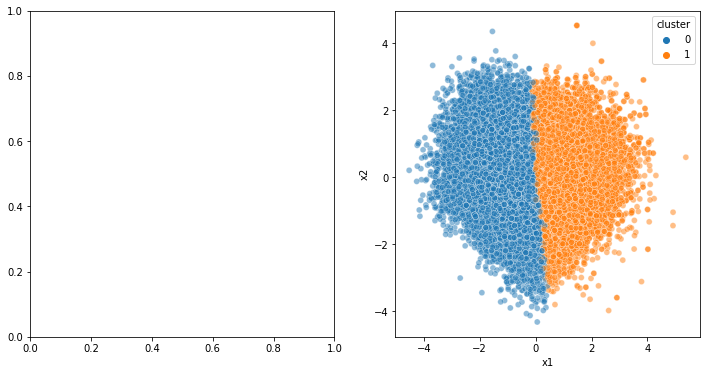

In [39]:
# Plots
fig, ax = plt.subplots(1, 2, figsize=(12,6))
sns.scatterplot(data=PCA_df,x='x1',y='x2',hue='cluster',legend="full",alpha=0.5,ax=ax[1])
sns.scatterplot(data=TSNE_df,x='x1',y='x2',hue='cluster',legend="full",alpha=0.5,ax=ax[0])
ax[0].set_title('Visualized on TSNE')
ax[1].set_title('Visualized on PCA')

# ***Regresión Logística***

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorization = TfidfVectorizer()
xv_train = vectorization.fit_transform(x_train)
xv_test = vectorization.transform(x_test)

In [41]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression()
LR.fit(xv_train,y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

# **Evaluación**

In [42]:
pred_lr=LR.predict(xv_test)

In [43]:
accuracy = accuracy_score(list(y_test), pred_lr)

print("Model Accuracy : ", accuracy)

Model Accuracy :  0.9868596881959911


In [44]:
from sklearn.metrics import classification_report

In [45]:
print(classification_report(y_test, pred_lr))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4687
           1       0.99      0.99      0.99      4293

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



[Text(0, 0.5, 'Reales(0)'), Text(0, 1.5, 'Falsas(1)')]

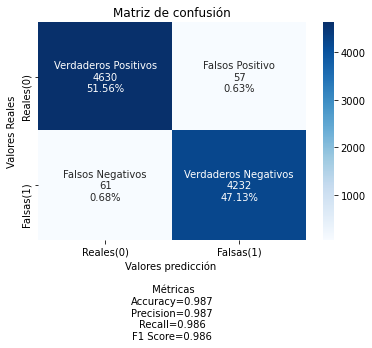

In [46]:
cm1 = confusion_matrix(y_test, pred_lr , labels=[0,1])

# group_names = ['True Neg','False Pos','False Neg','True Pos']
group_names = ['Verdaderos Positivos','Falsos Positivo','Falsos Negativos','Verdaderos Negativos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm1.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm1.flatten()/np.sum(cm1)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

precision = cm1[1,1] / sum(cm1[:,1])
recall    = cm1[1,1] / sum(cm1[1,:])
f1_score  = 2*precision*recall / (precision + recall)
stats_text = "\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(accuracy,precision,recall,f1_score)

ax= plt.subplot()
sns.heatmap(cm1, annot=labels, fmt='', cmap='Blues', ax = ax); #annot=True to annotate cells

ax.set_xlabel('Predicted label' + stats_text)

# labels, title and ticks
ax.set_xlabel("Valores predicción \n\n Métricas" + stats_text)
ax.set_ylabel('Valores Reales')
ax.set_title('Matriz de confusión')
ax.xaxis.set_ticklabels(['Reales(0)', 'Falsas(1)'])
ax.yaxis.set_ticklabels(['Reales(0)', 'Falsas(1)'])

# ***Arból de decisión***

In [47]:
from sklearn.tree import DecisionTreeClassifier

DT = DecisionTreeClassifier()
DT.fit(xv_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

# **Evaluación**

In [48]:
pred_dt = DT.predict(xv_test)

In [49]:
accuracy1 = accuracy_score(list(y_test), pred_dt)

print("Model Accuracy : ", accuracy1)

Model Accuracy :  0.9972160356347439


In [50]:
print(classification_report(y_test, pred_dt))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4687
           1       1.00      1.00      1.00      4293

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



[Text(0, 0.5, 'Reales(0)'), Text(0, 1.5, 'Falsas(1)')]

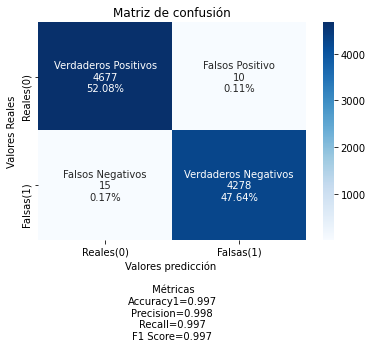

In [51]:
cm2 = confusion_matrix(y_test, pred_dt, labels=[0,1])

# group_names = ['True Neg','False Pos','False Neg','True Pos']
group_names = ['Verdaderos Positivos','Falsos Positivo','Falsos Negativos','Verdaderos Negativos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm2.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm2.flatten()/np.sum(cm2)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

precision = cm2[1,1] / sum(cm2[:,1])
recall    = cm2[1,1] / sum(cm2[1,:])
f1_score  = 2*precision*recall / (precision + recall)
stats_text = "\nAccuracy1={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(accuracy1,precision,recall,f1_score)

ax= plt.subplot()
sns.heatmap(cm2, annot=labels, fmt='', cmap='Blues', ax = ax); #annot=True to annotate cells

ax.set_xlabel('Predicted label' + stats_text)

# labels, title and ticks
ax.set_xlabel("Valores predicción \n\n Métricas" + stats_text)
ax.set_ylabel('Valores Reales')
ax.set_title('Matriz de confusión')
ax.xaxis.set_ticklabels(['Reales(0)', 'Falsas(1)'])
ax.yaxis.set_ticklabels(['Reales(0)', 'Falsas(1)'])

# ***Bosque aleatorio***

In [52]:
from sklearn.ensemble import RandomForestClassifier

RFC = RandomForestClassifier(random_state=0)
RFC.fit(xv_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

# **Evaluación**

In [53]:
pred_rfc = RFC.predict(xv_test)

In [54]:
accuracy2 = accuracy_score(list(y_test), pred_rfc)

print("Model Accuracy : ", accuracy2)

Model Accuracy :  0.9933184855233853


In [55]:
print(classification_report(y_test, pred_rfc))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4687
           1       0.99      0.99      0.99      4293

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



[Text(0, 0.5, 'Reales(0)'), Text(0, 1.5, 'Falsas(1)')]

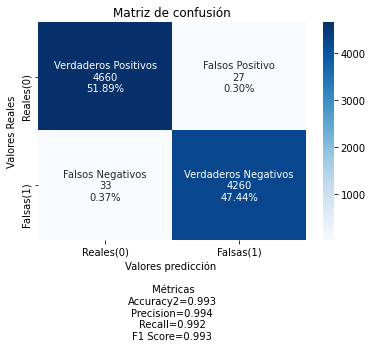

In [57]:
cm3 = confusion_matrix(y_test, pred_rfc , labels=[0,1])

# group_names = ['True Neg','False Pos','False Neg','True Pos']
group_names = ['Verdaderos Positivos','Falsos Positivo','Falsos Negativos','Verdaderos Negativos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm3.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm3.flatten()/np.sum(cm3)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

precision = cm3[1,1] / sum(cm3[:,1])
recall    = cm3[1,1] / sum(cm3[1,:])
f1_score  = 2*precision*recall / (precision + recall)
stats_text = "\nAccuracy2={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(accuracy2,precision,recall,f1_score)

ax= plt.subplot()
sns.heatmap(cm3, annot=labels, fmt='', cmap='Blues', ax = ax); #annot=True to annotate cells

ax.set_xlabel('Predicted label' + stats_text)

# labels, title and ticks
ax.set_xlabel("Valores predicción \n\n Métricas" + stats_text)
ax.set_ylabel('Valores Reales')
ax.set_title('Matriz de confusión')
ax.xaxis.set_ticklabels(['Reales(0)', 'Falsas(1)'])
ax.yaxis.set_ticklabels(['Reales(0)', 'Falsas(1)'])